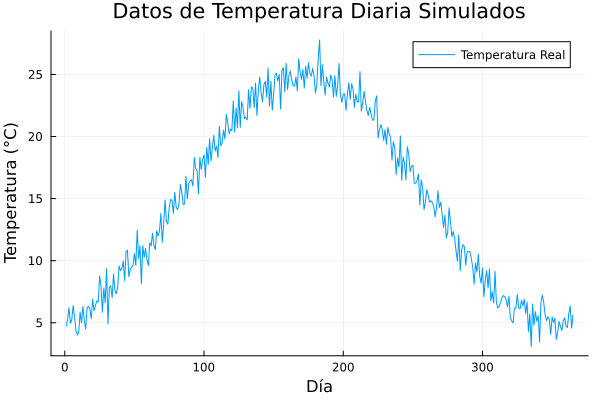

In [7]:
using Plots

# Generación de datos simulados
n_dias = 365
dias = 1:n_dias
true_temps = 15 .+ 10 .* sin.(2 * pi * (dias .- 80) ./ 365) .+ randn(n_dias) # Temperaturas con variabilidad aleatoria

# Graficar los datos simulados
plot(dias, true_temps, label="Temperatura Real", xlabel="Día", ylabel="Temperatura (°C)", title="Datos de Temperatura Diaria Simulados")